<a href="https://colab.research.google.com/github/bhaskarsaripella4/Tensorflow-Notebooks/blob/main/Tensorflow_Transformer_portugese_english.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -q -U tensorflow-text tensorflow

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 52.5 MB/s eta 0:00:00


In [ ]:
import logging
import time
import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds
import tensorflow as tf
import tensorflow_text

In [ ]:
examples, metadata = tfds.load('ted_hrlr_translate/pt_to_en', with_info = True, as_supervised=True)
examples_train, examples_val = examples['train'], examples['validation']


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/51785 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/ted_hrlr_translate/pt_to_en/1.0.0.incompleteH4SMXW/ted_hrlr_translate-trai…

Generating validation examples...:   0%|          | 0/1193 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/ted_hrlr_translate/pt_to_en/1.0.0.incompleteH4SMXW/ted_hrlr_translate-vali…

Generating test examples...:   0%|          | 0/1803 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/ted_hrlr_translate/pt_to_en/1.0.0.incompleteH4SMXW/ted_hrlr_translate-test…

Dataset ted_hrlr_translate downloaded and prepared to /root/tensorflow_datasets/ted_hrlr_translate/pt_to_en/1.0.0. Subsequent calls will reuse this data.


In [ ]:
for pt_examples, en_examples in examples_train.batch(3).take(1):
  print('portugese text')
  for pt in pt_examples.numpy():
    print(pt.decode('utf-8'))

  print('english text')
  for en in en_examples.numpy():
    print(en.decode('utf-8'))

portugese text
e quando melhoramos a procura , tiramos a única vantagem da impressão , que é a serendipidade .
mas e se estes fatores fossem ativos ?
mas eles não tinham a curiosidade de me testar .
english text
and when you improve searchability , you actually take away the one advantage of print , which is serendipity .
but what if it were active ?
but they did n't test for curiosity .


In [ ]:
model_name = 'ted_hrlr_translate_pt_en_converter'
tf.keras.utils.get_file(f'{model_name}.zip',f'https://storage.googleapis.com/download.tensorflow.org/models/{model_name}.zip',
                         cache_dir='.', cache_subdir='', extract=True)


184801/184801 [==============================] - 0s 0us/step


'./ted_hrlr_translate_pt_en_converter.zip'

In [ ]:
tokenizers = tf.saved_model.load(model_name)

In [ ]:
[item for item in dir(tokenizers.en) if not item.startswith('_')]

['detokenize',
 'get_reserved_tokens',
 'get_vocab_path',
 'get_vocab_size',
 'lookup',
 'tokenize',
 'tokenizer',
 'vocab']

In [ ]:
encoded = tokenizers.en.tokenize(en_examples)
round_trip = tokenizers.en.detokenize(encoded)
print(encoded)
print()
print(round_trip)

<tf.RaggedTensor [[2, 72, 117, 79, 1259, 1491, 2362, 13, 79, 150, 184, 311, 71, 103, 2308,
  74, 2679, 13, 148, 80, 55, 4840, 1434, 2423, 540, 15, 3]               ,
 [2, 87, 90, 107, 76, 129, 1852, 30, 3],
 [2, 87, 83, 149, 50, 9, 56, 664, 85, 2512, 15, 3]]>

tf.Tensor(
[b'and when you improve searchability , you actually take away the one advantage of print , which is serendipity .'
 b'but what if it were active ?'
 b"but they did n ' t test for curiosity ."], shape=(3,), dtype=string)


In [ ]:
# to convert tokens to token text
token = tokenizers.en.lookup(encoded)
print(token)

<tf.RaggedTensor [[b'[START]', b'and', b'when', b'you', b'improve', b'search', b'##ability',
  b',', b'you', b'actually', b'take', b'away', b'the', b'one', b'advantage',
  b'of', b'print', b',', b'which', b'is', b's', b'##ere', b'##nd', b'##ip',
  b'##ity', b'.', b'[END]']                                                 ,
 [b'[START]', b'but', b'what', b'if', b'it', b'were', b'active', b'?',
  b'[END]']                                                           ,
 [b'[START]', b'but', b'they', b'did', b'n', b"'", b't', b'test', b'for',
  b'curiosity', b'.', b'[END]']                                          ]>


In [ ]:
lengths = []

for pt_examples, en_examples in examples_train.batch(1024):
  pt_tokens = tokenizers.pt.tokenize(pt_examples)
  lengths.append(pt_tokens.row_lengths())

  en_tokens = tokenizers.en.tokenize(en_examples)
  lengths.append(en_tokens.row_lengths())
  print('.',end=' ', flush = True)

. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 

Text(0.5, 1.0, 'Maximum tokens per example:320')

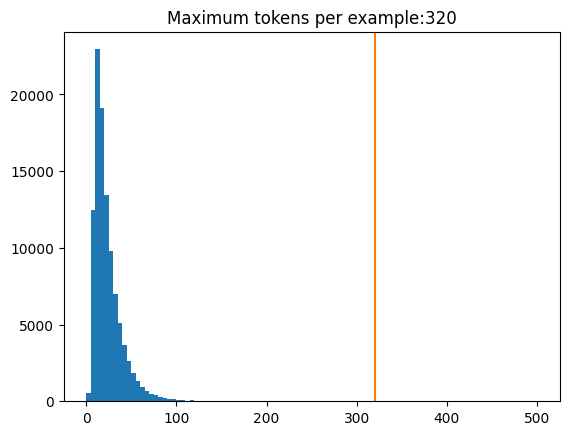

In [ ]:
all_lengths = np.concatenate(lengths)

plt.hist(all_lengths,np.linspace(0,500,101))
plt.ylim(plt.ylim())
max_length = max(all_lengths)
plt.plot([max_length,max_length],plt.ylim())
plt.title(f'Maximum tokens per example:{max_length}')

In [ ]:
# Create Data pipeline

MAX_TOKENS = 128
def prepare_batch(pt, en):
  